# Source panel method
A set of panels (line segments in 2D) can represent the surface of any solid body immersed in a potential flow. For example in the case of non-lifting bodies we can use source-sheet, a line with source/sinks distributed alongside it and the boundary codition of the flow not penetrating the center of each panel. Therfore the normal velocity at each panel is equal to zero. This is a very powerful idea, through it we obtain that the panel strengths are coupled to each other and we can write it as a linear system of equations.

For an arbitrary geometry, we need to build a set of panels according to some points that define  the geometry. In this notebook, we will read from a file a geometry definition corresponding to a **NACA0012 airfoil**, create a set of panels, and solve for the source-sheet strengths to get flow around the airfoil. Similarly to the notebook regarding the panel method over a cylinder but with a different geometry.
First import libraries:


In [1]:
import os
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

Next, we read the body geometry from a file using the NumPy function [`loadtxt()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html). The file comes from the [Airfoil Tools](http://airfoiltools.com/airfoil/details?airfoil=n0012-il) website and it contains a set of coordinates for the standard NACA0012 symmetric profile. We saved the file in the `resources` folder and load it from our local copy.

The geometry points get loaded into one NumPy array, so we separate the data into two arrays: `x,y` (for better code readability). The subsequent code will plot the geometry of the airfoil.

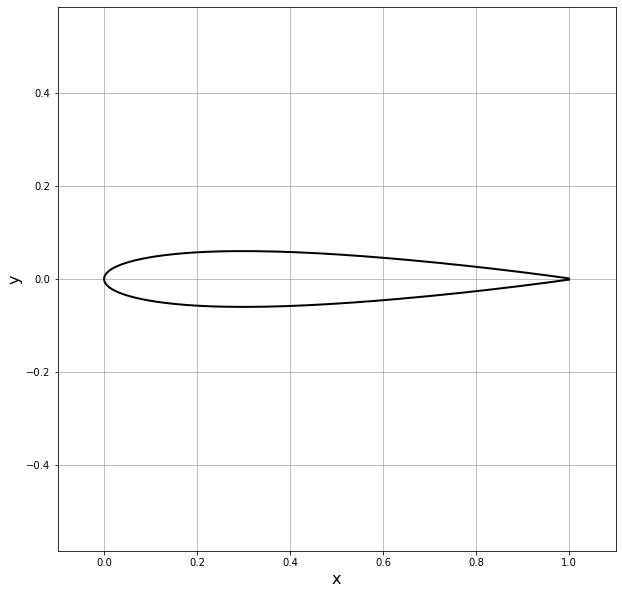

In [8]:
# read of the geometry from a data file
naca_filepath = 'naca0012.dat'
with open (naca_filepath, 'r') as file_name:
    x, y = np.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plot the geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

## Discretization into panels
We will create a discretization of the body geometry into panels (line segments in 2D). A panel's attributes are: its starting point, end point and mid-point, its length and its orientation. 
We modify the `Panel` class from our cylider notebook slightly, to work better for our study of flow over an airfoil. The only difference is that we identify points on the top or bottom surfaces with the words `upper` and `lower`, which is only used later for plotting results with different colors for the top and bottom surfaces of the profile.

In [23]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # control-point (center-point)
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # location of the panel
        if self.beta <= np.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

For the circular cylinder, the discretization into panels was really easy. This is the part that gets more complicated when you want to compute the flow around a general geometry.
The function below will create the panels from the geometry data that was read from a file. It is better to have small panels near the leading-edge and the trailing edge, where the curvature is large. One method to get a non uniform distribution around the airfoil is to first discretize a circle with diameter equal to the airfoil's chord, with the leading edge and trailing edge touching the circle at a node, as shown in the following sketch.
Then, we store the $x$-coordinates of the circle points, `x_circle`, which will also be the $x$-coordinates of the panel nodes, `x`, and project the $y$-coordinates of the circle points onto the airfoil by interpolation. We end up with a node distribution on the airfoil that is refined near the leading edge and the trailing edge.
With the discretization method just described, the function `define_panels()` returns an array of objects, each an instance of the class `Panel` and containing all information about a panel, given the desired number of panels and the set of body coordinates.

A few remarks about the implementation of the function `define_panels()`:

* we just need to compute the $x$-coordinates of the circle (`x_circle`) since the $y$-coordinates of the panel nodes will be computed by interpolation;
* we create a circle with `N+1` points, but the first and last points coincide;
* we extend our NumPy arrays by adding an extra value that is equal to the first one; thus we don't have to do anything special with the value `x[i+1]` in the different loops;
* the *while*-loop is used to find two consecutive points, (`x[I]`,`y[I]`) and (`x[I+1]`,`y[I+1]`), on the foil such that the interval [`x[I]`,`x[I+1]`] contains the value `x_ends[i]`; we use the keyword `break` to get out of the loop;
* once the two points have been identified, the value `y_ends[i]` is computed by interpolation.

In [43]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    R = (x.max() - x.min()) / 2  # radius of the circle
    x_center = (x.max() + x.min()) / 2  # x-coord of the center
    # define x-coord of the circle points
    x_circle = x_center + R * np.cos(np.linspace(0.0, 2 * np.pi, N + 1))
    
    x_ends = np.copy(x_circle)  # projection of the x-coord on the surface
    y_ends = np.empty_like(x_ends)  # initialization of the y-coord Numpy array

    x, y = np.append(x, x[0]), np.append(y, y[0])  # extend arrays using numpy.append
    
    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

Now we can use this function, calling it with a desired number of panels whenever we execute the cell below. We also plot the resulting geometry.

(-0.05, 1.05, -0.06601892, 0.06601892)

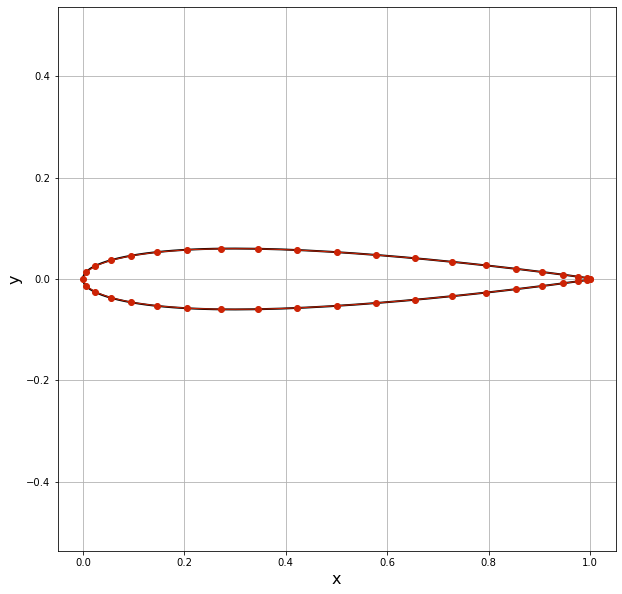

In [44]:
N = 40                           # number of panels
panels = define_panels(x, y, N)  # discretizes of the geometry into panels

# plot the geometry and the panels
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)
plt.axis('equal')


## Freestream conditions
The NACA0012 airfoil will be immersed in a uniform flow with velocity $U_\infty$ and an angle of attack $\alpha=0$. When creating a class, one is expecting to also create several instances of its objects. Here, we just have one freestream, so why define a class? Well, it makes the code more readable and does not block the programmer from using the variable names `u_inf` and `alpha` for something else outside of the class.
Also, every time we need the freestream condition as input to a function, we will just have to pass the object as an argument and not all the attributes of the freestream.

In [45]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  # degrees --> radians

In [46]:
# define and creates the object freestream
u_inf = 1.0                            # freestream spee
alpha = 0.0                            # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)  # instantiation of the object freestream

## Flow tangency boundary condition
Enforcing the flow-tangency condition on each *control point* approximately makes the body geometry correspond to a dividing streamline (and the approximation improves if we represented the body with more and more panels). So, for each panel $i$, we make $u_n=0$ at $(x_{c_i},y_{c_i})$, which leads to the equation derived in the previous lesson:

$$
\begin{equation}
u_{n_i} = \frac{\partial}{\partial n_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace = 0
\end{equation}
$$

i.e.

$$
\begin{equation}
\begin{split}
0 = & U_\infty \cos\beta_i + \frac{\sigma_i}{2} \\
& + \sum_{j=1,j\neq i}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i + \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i}{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
\end{split}
\end{equation}
$$
In the equation above, we calculate the derivative of the potential in the normal direction to enforce the flow tangency condition on each panel. But later, we will have to calculate the derivative in the tangential direction to compute the surface pressure coefficient. And, when we are interested in plotting the velocity field onto a mesh, we will have to calculate the derivative in the $x$- and $y$-direction.


In [47]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

## Building the linear system
Here, we build and solve the linear system of equations of the form

$$
\begin{equation}
[A][\sigma] = [b]
\end{equation}
$$

In building the matrix, below, we call the `integral()` function with the correct values for the last parameters: $\cos \beta_i$ and $\sin\beta_i$, corresponding to a derivative in the normal direction.

Finally, we use `linalg.solve()` from NumPy to solve the system and find the strength of each panel.

In [48]:
def build_matrix(panels):
    """
    Builds the source matrix.
    
    Parameters
    ----------
    panels: 1D array of Panel object
        The source panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        The source matrix (NxN matrix; N is the number of panels).
    """
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   np.cos(p_i.beta),
                                                   np.sin(p_i.beta))
    
    return A

def build_rhs(panels, freestream):
    """
    Builds the RHS of the linear system.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        RHS of the linear system.
    """
    b = np.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    
    return b

In [49]:
A = build_matrix(panels)           # compute the singularity matrix
b = build_rhs(panels, freestream)  # compute the freestream RHS
# solve the linear system
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

From Bernoulli's equation, the pressure coefficient on the $i$-th panel is

$$
\begin{equation}
C_{p_i} = 1-\left(\frac{u_{t_i}}{U_\infty}\right)^2
\end{equation}
$$

where $u_{t_i}$ is the tangential component of the velocity at the center point of the $i$-th panel,

$$
\begin{equation}
\begin{split}
u_{t_i} = & -U_\infty \sin\beta_i \\
& + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
\end{split}
\end{equation}
$$

with

$$
\begin{equation}
\frac{\partial x_{c_i}}{\partial t_i} = -\sin\beta_i \quad\text{and} \quad \frac{\partial y_{c_i}}{\partial t_i} = \cos\beta_i
\end{equation}
$$

Notice that below we call the function `integral()` with different arguments: $-\sin\beta_i$ and $\cos\beta_i$ to get the derivation in the tangential direction.

In [50]:
def get_tangential_velocity(panels, freestream):
    """
    Computes the tangential velocity on the surface of the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   -np.sin(p_i.beta),
                                                   np.cos(p_i.beta))
    
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    sigma = np.array([panel.sigma for panel in panels])
    
    vt = np.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [51]:
# compute the tangential velocity at the center-point of each panel
get_tangential_velocity(panels, freestream)

In [52]:
def get_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients on the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [53]:
# computes the surface pressure coefficients
get_pressure_coefficient(panels, freestream)

### Theoretical solution
There is a classical method to obtain the theoretical characteristics of airfoils, known as *Theodorsen's method*. It uses the Joukowski transformation but is able to deal with any airfoil by an additional transformation between a "near circle" and a circle. The method is hairy indeed! But the resulting values of pressure coefficient are provided for some airfoils in table form in the 1945 [NACA Report No.824](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930090976.pdf), available from the NASA web server (see p. 71). 

The values of $(u/U_{\infty})^2$ are given for several stations along the chord length. We transcribed them here, saving them into an array:

In [56]:
voverVsquared=np.array([0.0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411,
                           1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044,
                           0.956, 0.906, 0.0])
print(voverVsquared)
xtheo=np.array([0.0, 0.5, 1.25, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0, 30.0,
                   40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 95.0, 100.0])
xtheo /= 100
print(xtheo)

[0.    0.64  1.01  1.241 1.378 1.402 1.411 1.411 1.399 1.378 1.35  1.288
 1.228 1.166 1.109 1.044 0.956 0.906 0.   ]
[0.     0.005  0.0125 0.025  0.05   0.075  0.1    0.15   0.2    0.25
 0.3    0.4    0.5    0.6    0.7    0.8    0.9    0.95   1.    ]


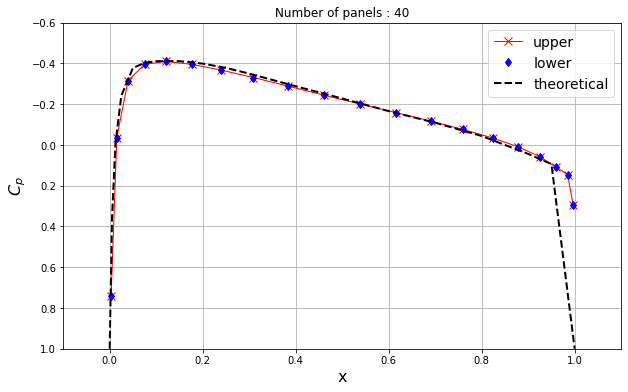

In [58]:
# plot the surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
plt.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)
plt.legend(loc='best', prop={'size':14})
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -0.6)
plt.title('Number of panels : {}'.format(N));